In [ ]:
pip install tensorflow

In [ ]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import cv2
import tqdm
import tarfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

In [ ]:
name_of_atris = "sample_data/lfw_attributes_ae.txt"

name_of_images = "sample_data/lfw-deepfunneled_ae.tgz"

name_raw_images = "sample_data/lfw_ae.tgz"

In [ ]:
def decode_image_from_raw_bytes(raw_bytes):
    images1 = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    images1 = cv2.cvtColor(images1, cv2.COLOR_BGR2RGB)
    return images1

In [ ]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Reading attris
    df_attris = pd.read_csv(name_of_atris, sep='\t', skiprows=1)
    df_attris = pd.DataFrame(df_attris.iloc[:, :-1].values, columns=df_attris.columns[1:])
    images_with_attris = set(map(tuple, df_attris[["person", "imagenum"]].values))

    # Reading photos
    all_photos1 = []
    photo_ids1 = []

    with tarfile.open(name_raw_images if use_raw else name_of_images) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            if m.isfile() and m.name.endswith(".jpg"):
                # Preparing image
                images1 = decode_image_from_raw_bytes(f.extractfile(m).read())

                # only croping faces and resizing it
                images1 = images1[dy:-dy, dx:-dx]
                images1 = cv2.resize(images1, (dimx, dimy))

                # Parsing person 
                fname1 = os.path.split(m.name)[-1]
                fname1_splitted = fname1[:-4].replace('_', ' ').split()
                person_ids1 = ' '.join(fname1_splitted[:-1])
                photo_number1 = int(fname1_splitted[-1])
                if (person_ids1, photo_number1) in images_with_attris:
                    all_photos1.append(images1)
                    photo_ids1.append({'person': person_ids1, 'imagenum': photo_number1})

    photo_ids1 = pd.DataFrame(photo_ids1)
    all_photos1 = np.stack(all_photos1).astype('uint8')

    # Preserving photo_ids1 
    all_attris = photo_ids1.merge(df_attris, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos1, all_attris

In [ ]:
X1, attris = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


In [ ]:
X1 = X1.astype('float32') / 255.0 - 0.5

In [ ]:
import tensorflow as tf

In [ ]:
def show_image(x):
    plt.figure(figsize=(1,1))
    plt.imshow(np.clip(x + 0.5, 0, 1))

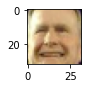

In [ ]:
show_image(X1[8])

In [ ]:
X_train1 , X1_test = train_test_split(X1, test_size=0.1, random_state=42)

In [ ]:
def build_autoencoder(image_shape, code1_size):
    # implementing encoder
    encoder = Sequential()
    encoder.add(InputLayer(image_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code1_size))

    # implementing decoder
    decoder = Sequential()
    decoder.add(InputLayer((code1_size,)))
    decoder.add(Dense(np.prod(image_shape))) 
    decoder.add(Reshape(image_shape))

    return encoder, decoder

In [ ]:
IMAGE_SHAPE = X1.shape[1:]
encoder, decoder = build_autoencoder(IMAGE_SHAPE, 256)

input = Input(IMAGE_SHAPE)
code1 = encoder(input)
reconstruction = decoder(code1)

auto_encoder = Model(input,reconstruction)
auto_encoder.compile(optimizer='adam', loss='mse')

auto_encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 256)               786688    
_________________________________________________________________
sequential_3 (Sequential)    (None, 32, 32, 3)         789504    
Total params: 1,576,192
Trainable params: 1,576,192
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = auto_encoder.fit(x=X_train1, y=X_train1, epochs=20,
                validation_data=(X1_test, X1_test))

Epoch 1/20
370/370 [==============================] - 7s 18ms/step - loss: 0.0138 - val_loss: 0.0041
Epoch 2/20
370/370 [==============================] - 7s 18ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 3/20
370/370 [==============================] - 6s 17ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 4/20
370/370 [==============================] - 6s 16ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/20
370/370 [==============================] - 6s 17ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 6/20
370/370 [==============================] - 6s 17ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 7/20
370/370 [==============================] - 6s 17ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 8/20
370/370 [==============================] - 6s 17ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 9/20
370/370 [==============================] - 7s 18ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 10/20
370/370 [==============================] - 6s 17ms/step - loss: 0.0018 - val_lo

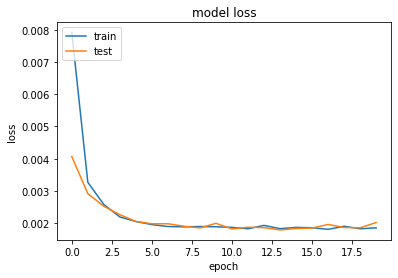

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()